<a href="https://colab.research.google.com/github/robinsonmirandaco/EDA_CredXAI/blob/main/01_EDA_CredXAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CredXAI – EDA (v1)

**Autor:** Robinson Miranda  
**Proyecto:** TFM – UNIR – Máster en Inteligencia Artificial  
**Objetivo del Notebook:**  
Explorar el dataset sintético CredXAI, validar la calidad de datos, ejecutar análisis exploratorio (EDA) inicial.



In [ ]:
# =======================================
#  CredXAI-RM — Setup Inicial
# =======================================
from google.colab import drive
drive.mount('/content/drive')

#Configuración de tus rutas (ajusta 'MyDrive' si tu carpeta se llama distinto)
PROJ_DIR = "/content/drive/MyDrive/Master_of_AI/TFM"
DATA_DIR = f"{PROJ_DIR}/Dataset/version1"
OUT_DIR  = f"{PROJ_DIR}/outputs"
NOTE_DIR = f"{PROJ_DIR}/notebooks"

import os
for p in [PROJ_DIR, DATA_DIR, OUT_DIR, NOTE_DIR]:
    os.makedirs(p, exist_ok=True)

print("Project:", PROJ_DIR)
print("Data   :", DATA_DIR)
print("Outputs:", OUT_DIR)
print("Notes  :", NOTE_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project: /content/drive/MyDrive/Master_of_AI/TFM
Data   : /content/drive/MyDrive/Master_of_AI/TFM/Dataset/version1
Outputs: /content/drive/MyDrive/Master_of_AI/TFM/outputs
Notes  : /content/drive/MyDrive/Master_of_AI/TFM/notebooks


**Importación del Dataset**


In [ ]:
import pandas as pd
import shutil

# Ruta del archivo original (ajusta el nombre exacto si difiere)
ORIGINAL_PATH = f"{DATA_DIR}/credxai_synth_v1.csv"
WORKING_PATH  = f"{OUT_DIR}/credxai_synth_v1_working.csv"

# Copiar el dataset original → outputs
shutil.copy(ORIGINAL_PATH, WORKING_PATH)

# Cargar el dataset de trabajo
df = pd.read_csv(WORKING_PATH)

print("✔ Copia creada y cargada correctamente.")
print("Dataset de trabajo:", WORKING_PATH)
print("Filas:", df.shape[0], " | Columnas:", df.shape[1])
df.head(5)


✔ Copia creada y cargada correctamente.
Dataset de trabajo: /content/drive/MyDrive/Master_of_AI/TFM/outputs/credxai_synth_v1_working.csv
Filas: 5000  | Columnas: 18


,application_id,application_creation_date,credit_amount,credit_usage,business_age_months,business_industry,business_state,monthly_income_avg,total_deposits_3m,revenue_volatility_3m,request_ratio,dti_monthly,nsf_count_3m,negative_days_3m,owner_percentage,owner_credit_score,p_viable,application_status
0,CREDXAI-00001,2023-06-08,65119.01,equipment,14,NAICS_444_BuildingMaterial,AZ,31423.29,86800.05,0.745,2.072,0.542,1,3,77.8,571,0.835,approved
1,CREDXAI-00002,2025-08-23,36058.07,equipment,94,NAICS_541_ProfessionalServices,CA,27885.55,79161.32,0.552,1.293,0.434,3,3,84.4,731,0.918,approved
2,CREDXAI-00003,2024-10-21,9782.59,working_capital,32,NAICS_541_ProfessionalServices,NY,13293.69,42202.89,0.650,0.736,0.432,4,3,81.8,604,0.466,rejected
3,CREDXAI-00004,2024-04-17,31340.25,debt_refinance,30,NAICS_442_Furniture,CO,18121.27,51841.87,0.726,1.729,0.306,5,7,53.8,729,0.495,approved
4,CREDXAI-00005,2022-08-07,14167.70,working_capital,32,NAICS_561_AdminSupport,FL,13954.20,42403.16,0.597,1.015,0.311,3,4,66.7,663,0.608,approved


## Paso 1 — Contexto de negocio y propósito del EDA

### Propósito del EDA
Comprender la estructura, calidad y comportamiento general de las variables que intervienen en el modelo híbrido CredXAI:
- Detectar valores atípicos, faltantes y errores lógicos.  
- Verificar consistencia de reglas suaves (edad del negocio, rango FICO, montos, etc.).  
- Explorar patrones de riesgo y variables con mayor influencia en la viabilidad (`viable`).  
- Documentar hallazgos y decisiones para auditoría futura (transparencia XAI).

### Preguntas guía
1. ¿Qué características distinguen a los negocios viables vs no viables?  
2. ¿Cómo se distribuyen las variables financieras y de perfil?  
3. ¿Qué relaciones iniciales existen entre `loan_product_type`, `business_industry` y `viable`?

---

**Checklist del Paso 1:**  
- [x] Dataset cargado desde copia en `outputs`  
- [x] Contexto de negocio documentado (esta celda)  
- [x] Diccionario de variables preliminar (siguiente acción)


**Diccionario de variables preliminar**

In [ ]:
import numpy as np

# Generación del diccionario preliminar de variables
def summarize_variable(series: pd.Series):
    info = {
        "dtype": str(series.dtype),
        "n_missing": series.isna().sum(),
        "unique_values": series.nunique(dropna=True)
    }
    if pd.api.types.is_numeric_dtype(series):
        info.update({
            "min": float(series.min()) if series.notna().any() else np.nan,
            "p25": float(series.quantile(0.25)) if series.notna().any() else np.nan,
            "median": float(series.median()) if series.notna().any() else np.nan,
            "p75": float(series.quantile(0.75)) if series.notna().any() else np.nan,
            "max": float(series.max()) if series.notna().any() else np.nan,
        })
    else:
        top = series.value_counts(dropna=True).head(3)
        info["top_values"] = "; ".join([f"{k} ({v})" for k, v in top.items()])
    return info

# Aplicación de función a todas las columnas
data_dict = pd.DataFrame({
    col: summarize_variable(df[col]) for col in df.columns
}).T.reset_index().rename(columns={"index": "column"})

display(data_dict.head(10))

# Guardado del borrador en outputs
dict_path = f"{OUT_DIR}/credxai_data_dictionary_draft.csv"
data_dict.to_csv(dict_path, index=False)
print(f"✔ Diccionario preliminar guardado en: {dict_path}")


,column,dtype,n_missing,unique_values,top_values,min,p25,median,p75,max
0,application_id,object,0,5000,CREDXAI-05000 (1); CREDXAI-00001 (1); CREDXAI-...,NaN,NaN,NaN,NaN,NaN
1,application_creation_date,object,0,1361,2025-09-18 (12); 2024-08-26 (11); 2022-03-29 (10),NaN,NaN,NaN,NaN,NaN
2,credit_amount,float64,0,4686,NaN,5000.0,9069.0925,14906.27,24370.0975,163459.98
3,credit_usage,object,0,7,working_capital (1631); debt_refinance (877); ...,NaN,NaN,NaN,NaN,NaN
4,business_age_months,int64,0,170,NaN,3.0,16.0,30.0,62.0,180.0
5,business_industry,object,0,10,NAICS_541_ProfessionalServices (784); NAICS_72...,NaN,NaN,NaN,NaN,NaN
6,business_state,object,0,20,FL (575); CA (540); TX (463),NaN,NaN,NaN,NaN,NaN
7,monthly_income_avg,float64,0,4948,NaN,3000.0,8413.295,12762.03,19506.77,100000.0
8,total_deposits_3m,float64,0,4997,NaN,7286.33,24864.92,38215.21,58613.6825,358961.34
9,revenue_volatility_3m,float64,0,440,NaN,0.355,0.57975,0.635,0.691,0.888


✔ Diccionario preliminar guardado en: /content/drive/MyDrive/Master_of_AI/TFM/outputs/credxai_data_dictionary_draft.csv


**Enriqueciendo el diccionario con propósito y transformación prevista.**

In [ ]:
# Añadir columnas para descripción, propósito y transformación
data_dict["description"] = ""
data_dict["business_purpose"] = ""
data_dict["transformation_plan"] = ""

# Reordenar para que se vea más legible
cols_order = [
    "column", "dtype", "n_missing", "unique_values",
    "min", "p25", "median", "p75", "max", "top_values",
    "description", "business_purpose", "transformation_plan"
]
data_dict = data_dict.reindex(columns=cols_order, fill_value=np.nan)

# Guardar la nueva versión enriquecida
enriched_path = f"{OUT_DIR}/credxai_data_dictionary_enriched.csv"
data_dict.to_csv(enriched_path, index=False)
print(f"✔ Diccionario enriquecido guardado en: {enriched_path}")

# Mostrar vista previa
data_dict.head(10)

✔ Diccionario enriquecido guardado en: /content/drive/MyDrive/Master_of_AI/TFM/outputs/credxai_data_dictionary_enriched.csv


,column,dtype,n_missing,unique_values,min,p25,median,p75,max,top_values,description,business_purpose,transformation_plan
0,application_id,object,0,5000,NaN,NaN,NaN,NaN,NaN,CREDXAI-05000 (1); CREDXAI-00001 (1); CREDXAI-...,,,
1,application_creation_date,object,0,1361,NaN,NaN,NaN,NaN,NaN,2025-09-18 (12); 2024-08-26 (11); 2022-03-29 (10),,,
2,credit_amount,float64,0,4686,5000.0,9069.0925,14906.27,24370.0975,163459.98,NaN,,,
3,credit_usage,object,0,7,NaN,NaN,NaN,NaN,NaN,working_capital (1631); debt_refinance (877); ...,,,
4,business_age_months,int64,0,170,3.0,16.0,30.0,62.0,180.0,NaN,,,
5,business_industry,object,0,10,NaN,NaN,NaN,NaN,NaN,NAICS_541_ProfessionalServices (784); NAICS_72...,,,
6,business_state,object,0,20,NaN,NaN,NaN,NaN,NaN,FL (575); CA (540); TX (463),,,
7,monthly_income_avg,float64,0,4948,3000.0,8413.295,12762.03,19506.77,100000.0,NaN,,,
8,total_deposits_3m,float64,0,4997,7286.33,24864.92,38215.21,58613.6825,358961.34,NaN,,,
9,revenue_volatility_3m,float64,0,440,0.355,0.57975,0.635,0.691,0.888,NaN,,,


**Clasificación de las variables según su origen:**

- **Capturada**: viene directamente del formulario o fuente original.

- **Derivada**: calculada a partir de otras variables (por transformación o ratio).

- **Calculada**: obtenida mediante una fórmula explícita o proceso analítico.

*Esto nos permite estructurar el pipeline y luego aplicar transformaciones con trazabilidad (auditable y XAI-compatible).*

In [ ]:
# Clasificación definitiva CredXAI-RM (v1.0)
classification_final = {
    "application_id": "capturada",
    "application_creation_date": "capturada",
    "credit_amount": "capturada",
    "credit_usage": "capturada",
    "business_age_months": "derivada",
    "business_industry": "capturada",
    "business_state": "capturada",
    "monthly_income_avg": "calculada",
    "total_deposits_3m": "calculada",
    "revenue_volatility_3m": "calculada",
    "request_ratio": "derivada",
    "dti_monthly": "derivada",
    "nsf_count_3m": "calculada",
    "negative_days_3m": "calculada",
    "owner_percentage": "capturada",
    "owner_credit_score": "capturada",
    "p_viable": "calculada",
    "application_status": "derivada"
}

# Aplicar y guardar
data_dict["origin_type"] = data_dict["column"].map(classification_final).fillna("")

final_path = f"{OUT_DIR}/credxai_data_dictionary_final.csv"
data_dict.to_csv(final_path, index=False)
print(f"✔ Clasificación definitiva aplicada y guardada en: {final_path}")
data_dict[["column", "origin_type"]]


✔ Clasificación definitiva aplicada y guardada en: /content/drive/MyDrive/Master_of_AI/TFM/outputs/credxai_data_dictionary_final.csv


,column,origin_type
0,application_id,capturada
1,application_creation_date,capturada
2,credit_amount,capturada
3,credit_usage,capturada
4,business_age_months,derivada
5,business_industry,capturada
6,business_state,capturada
7,monthly_income_avg,calculada
8,total_deposits_3m,calculada
9,revenue_volatility_3m,calculada


In [ ]:
# === Validación de estructura y tipos esperados ===

expected_types = {
    "application_id": "object",
    "application_creation_date": "datetime64[ns]",
    "credit_amount": "float64",
    "credit_usage": "object",
    "business_age_months": "int64",
    "business_industry": "object",
    "business_state": "object",
    "monthly_income_avg": "float64",
    "total_deposits_3m": "float64",
    "revenue_volatility_3m": "float64",
    "request_ratio": "float64",
    "dti_monthly": "float64",
    "nsf_count_3m": "int64",
    "negative_days_3m": "int64",
    "owner_percentage": "float64",
    "owner_credit_score": "int64",
    "p_viable": "float64",
    "application_status": "object"
}

# Intentar convertir los tipos donde sea necesario
for col, t in expected_types.items():
    if col not in df.columns:
        print(f"⚠ Falta columna: {col}")
        continue
    if "datetime" in t:
        df[col] = pd.to_datetime(df[col], errors="coerce")
    elif "float" in t:
        df[col] = pd.to_numeric(df[col], errors="coerce").astype("float64")
    elif "int" in t:
        df[col] = pd.to_numeric(df[col], errors="coerce").round(0).astype("Int64")
    else:
        df[col] = df[col].astype("object")

# Reporte resumen de tipos reales vs esperados
types_report = pd.DataFrame({
    "expected": expected_types,
    "actual": df.dtypes.astype(str)
})
types_report["status"] = np.where(types_report["expected"] == types_report["actual"], "OK", "DESALINEADO")
display(types_report)

# Guardar dataset limpio temporal
clean_path = f"{OUT_DIR}/credxai_synth_v1_clean.csv"
df.to_csv(clean_path, index=False)
print(f"✔ Validación completada. Dataset limpio guardado en: {clean_path}")


,expected,actual,status
application_id,object,object,OK
application_creation_date,datetime64[ns],datetime64[ns],OK
credit_amount,float64,float64,OK
credit_usage,object,object,OK
business_age_months,int64,Int64,DESALINEADO
business_industry,object,object,OK
business_state,object,object,OK
monthly_income_avg,float64,float64,OK
total_deposits_3m,float64,float64,OK
revenue_volatility_3m,float64,float64,OK


✔ Validación completada. Dataset limpio guardado en: /content/drive/MyDrive/Master_of_AI/TFM/outputs/credxai_synth_v1_clean.csv


,column,n_missing,pct_missing
0,application_id,0,0.000000
1,application_creation_date,0,0.000000
2,credit_amount,0,0.000000
3,credit_usage,0,0.000000
4,business_age_months,0,0.000000
5,business_industry,0,0.000000
6,business_state,0,0.000000
7,monthly_income_avg,0,0.000000
8,total_deposits_3m,0,0.000000
9,revenue_volatility_3m,0,0.000000


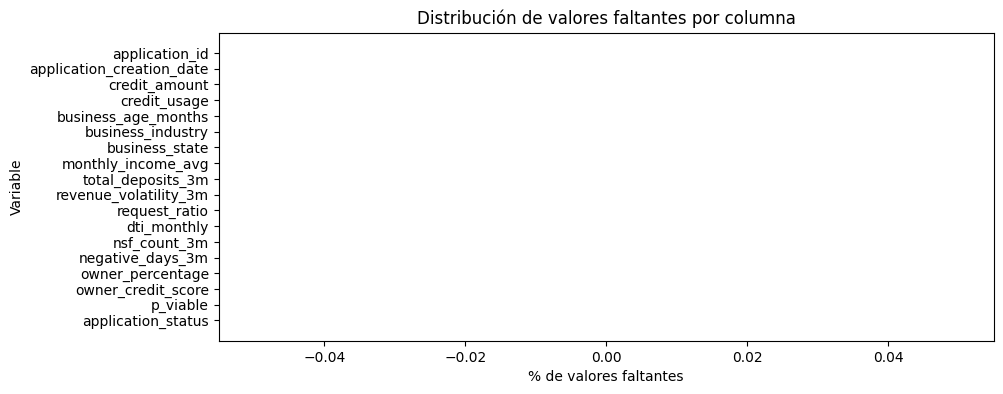

✔ Informe de valores faltantes guardado en: /content/drive/MyDrive/Master_of_AI/TFM/outputs/credxai_missing_values_report.csv


In [ ]:
import matplotlib.pyplot as plt

# === Paso 2.1 — Resumen de valores faltantes ===

# Calcular cantidad y porcentaje de NA
na_summary = (
    df.isna()
    .sum()
    .reset_index()
    .rename(columns={"index": "column", 0: "n_missing"})
)
na_summary["pct_missing"] = (na_summary["n_missing"] / len(df)) * 100

# Mostrar tabla ordenada
na_summary = na_summary.sort_values("pct_missing", ascending=False)
display(na_summary.style.background_gradient(cmap="Reds"))

# Visualización rápida
plt.figure(figsize=(10,4))
plt.barh(na_summary["column"], na_summary["pct_missing"])
plt.xlabel("% de valores faltantes")
plt.ylabel("Variable")
plt.title("Distribución de valores faltantes por columna")
plt.gca().invert_yaxis()
plt.show()

# Guardar informe
na_summary_path = f"{OUT_DIR}/credxai_missing_values_report.csv"
na_summary.to_csv(na_summary_path, index=False)
print(f"✔ Informe de valores faltantes guardado en: {na_summary_path}")


**Detectar valores imposibles o sospechosos (“reglas suaves”).**

**Objetivo**:
Comprobar que los valores numéricos y categóricos cumplan rangos lógicos básicos y reglas financieras realistas.
Esto permite encontrar errores de simulación o inconsistencias antes de entrenar el modelo.

In [ ]:
# === Paso 2.2 — Reglas suaves de validación de datos (versión corregida) ===

issues = []

def flag(cond, msg):
    count = int(cond.sum())
    if count > 0:
        issues.append(f"{msg} → {count} filas")

# 1. Monto de crédito
if "credit_amount" in df.columns:
    flag(df["credit_amount"] <= 0, "credit_amount ≤ 0 (inválido)")
    flag(df["credit_amount"] > 1_000_000, "credit_amount > 1M USD (outlier extremo)")

# 2. Puntaje de crédito
if "owner_credit_score" in df.columns:
    flag(~df["owner_credit_score"].between(300, 850, inclusive="both"), "owner_credit_score fuera de rango [300, 850]")

# 3. Antigüedad del negocio
if "business_age_months" in df.columns:
    flag(df["business_age_months"] < 0, "business_age_months < 0")
    flag(df["business_age_months"] > 600, "business_age_months > 50 años (revisar)")

# 4. Ratios financieros
if set(["monthly_income_avg", "credit_amount"]).issubset(df.columns):
    ratio = df["credit_amount"] / df["monthly_income_avg"]
    flag(ratio > 20, "credit_amount / income > 20 (riesgo extremo o error)")

if "dti_monthly" in df.columns:
    flag(df["dti_monthly"] > 1, "dti_monthly > 1 (más de 100% deuda/ingreso)")

# 5. Variables de flujo
if "total_deposits_3m" in df.columns:
    flag(df["total_deposits_3m"] <= 0, "total_deposits_3m ≤ 0")
if "negative_days_3m" in df.columns:
    flag(df["negative_days_3m"] < 0, "negative_days_3m < 0")
    flag(df["negative_days_3m"] > 90, "negative_days_3m > 90 (no plausible en 3 meses)")

# 6. Campos categóricos
if "business_state" in df.columns:
    valid_states = [
        "AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA","ME","MD",
        "MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA","RI",
        "SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"
    ]
    cond_invalid_state = ~df["business_state"].isin(valid_states)
    flag(cond_invalid_state, "business_state inválido o fuera de EE.UU.")

# Mostrar resultados
print("⚑ Reglas suaves verificadas:")
if len(issues) == 0:
    print("✔ No se encontraron violaciones críticas.")
else:
    for i, rule in enumerate(issues, 1):
        print(f"{i}. {rule}")

# Guardar informe
rules_report_path = f"{OUT_DIR}/credxai_rules_report.txt"
with open(rules_report_path, "w") as f:
    f.write("\n".join(issues) if issues else "Sin violaciones críticas.")
print(f"\nInforme de reglas suaves guardado en: {rules_report_path}")



⚑ Reglas suaves verificadas:
✔ No se encontraron violaciones críticas.

Informe de reglas suaves guardado en: /content/drive/MyDrive/Master_of_AI/TFM/outputs/credxai_rules_report.txt


**Detección de duplicados y consistencias básicas.**

**Objetivo**:
Comprobar que no existan registros duplicados, ni por fila completa ni por identificador (application_id), y revisar que los identificadores sean únicos y válidos.

In [ ]:
# === Paso 2.3 — Duplicados y consistencias básicas ===

summary = {}

# 1. Duplicados globales
dup_total = df.duplicated().sum()
summary["duplicados_totales"] = dup_total

# 2. Duplicados por application_id (si existe)
if "application_id" in df.columns:
    dup_ids = df["application_id"].duplicated().sum()
    summary["duplicados_por_id"] = dup_ids
    summary["ids_unicos"] = df["application_id"].nunique()
else:
    summary["duplicados_por_id"] = "N/A"
    summary["ids_unicos"] = "N/A"

# 3. Revisión básica de valores nulos en IDs o fechas
summary["application_id_nulos"] = int(df["application_id"].isna().sum()) if "application_id" in df.columns else "N/A"
summary["application_creation_date_nulos"] = int(df["application_creation_date"].isna().sum()) if "application_creation_date" in df.columns else "N/A"

# 4. Fechas fuera de rango (2022–2025)
if "application_creation_date" in df.columns:
    bad_dates = ~df["application_creation_date"].between("2022-01-01", "2025-12-31")
    summary["fechas_fuera_de_rango"] = int(bad_dates.sum())
else:
    summary["fechas_fuera_de_rango"] = "N/A"

# Mostrar resumen
import pandas as pd
summary_df = pd.DataFrame(list(summary.items()), columns=["verificación", "resultado"])
display(summary_df)

# Guardar informe
dup_report_path = f"{OUT_DIR}/credxai_duplicates_report.csv"
summary_df.to_csv(dup_report_path, index=False)
print(f"✔ Informe de duplicados guardado en: {dup_report_path}")

,verificación,resultado
0,duplicados_totales,0
1,duplicados_por_id,0
2,ids_unicos,5000
3,application_id_nulos,0
4,application_creation_date_nulos,0
5,fechas_fuera_de_rango,0


✔ Informe de duplicados guardado en: /content/drive/MyDrive/Master_of_AI/TFM/outputs/credxai_duplicates_report.csv


**Análisis univariante**

**Objetivo general**

1. Explorar la distribución y dispersión de cada variable numérica.

2. Analizar frecuencias y categorías en variables cualitativas.

3. Identificar valores atípicos y rangos dominantes.

4. Generar un resumen visual y estadístico limpio (para incluir en tu notebook y TFM).

**Resumen estadístico y de dispersión de variables numéricas**

**Objetivo:**
Obtener medidas de tendencia central, dispersión y forma (asimetría y curtosis) para identificar posibles valores extremos o distribuciones sesgadas.

In [ ]:
# === Paso 3.1 — Resumen estadístico univariante (numéricas) ===
import numpy as np
import pandas as pd

# Seleccionar solo columnas numéricas
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Crear resumen
summary_stats = df[num_cols].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T

# Añadir métricas de forma
summary_stats["missing_%"] = df[num_cols].isna().mean() * 100
summary_stats["skewness"] = df[num_cols].skew()
summary_stats["kurtosis"] = df[num_cols].kurt()
summary_stats["dtype"] = df[num_cols].dtypes.values

# Reordenar columnas para legibilidad
summary_stats = summary_stats[[
    "dtype", "count", "missing_%", "mean", "std",
    "min", "1%", "5%", "25%", "50%", "75%", "95%", "99%", "max",
    "skewness", "kurtosis"
]]

display(summary_stats.style.background_gradient(cmap="Blues", subset=["mean", "std", "skewness", "kurtosis"]))

# Guardar informe
num_summary_path = f"{OUT_DIR}/credxai_numeric_summary.csv"
summary_stats.to_csv(num_summary_path)
print(f"✔ Resumen estadístico numérico guardado en: {num_summary_path}")

,dtype,count,missing_%,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max,skewness,kurtosis
credit_amount,float64,5000.000000,0.000000,19394.915146,15439.354275,5000.000000,5000.000000,5000.000000,9069.092500,14906.270000,24370.097500,48894.121000,77283.984000,163459.980000,2.533381,10.783757
business_age_months,Int64,5000.000000,0.000000,44.702600,38.507250,3.000000,3.000000,6.000000,16.000000,30.000000,62.000000,128.000000,152.000000,180.000000,1.245590,0.655396
monthly_income_avg,float64,5000.000000,0.000000,15598.666420,10690.815530,3000.000000,3076.444400,4621.698500,8413.295000,12762.030000,19506.770000,36105.790000,54108.591500,100000.000000,2.173951,8.017658
total_deposits_3m,float64,5000.000000,0.000000,46814.800272,32544.513242,7286.330000,9457.606000,13736.656000,24864.920000,38215.210000,58613.682500,108045.588000,165309.711000,358961.340000,2.259160,9.097030
revenue_volatility_3m,float64,5000.000000,0.000000,0.633891,0.082129,0.355000,0.437000,0.492000,0.579750,0.635000,0.691000,0.766000,0.821000,0.888000,-0.102801,-0.128118
request_ratio,float64,5000.000000,0.000000,1.261037,0.449257,0.400000,0.525990,0.658900,0.917000,1.165000,1.557000,2.150050,2.410040,2.499000,0.655489,-0.240271
dti_monthly,float64,5000.000000,0.000000,0.347414,0.151977,0.050000,0.050000,0.106000,0.232000,0.344000,0.458000,0.604000,0.682010,0.787000,0.147633,-0.647162
nsf_count_3m,Int64,5000.000000,0.000000,3.371600,1.888128,0.000000,0.000000,1.000000,2.000000,3.000000,5.000000,7.000000,8.000000,12.000000,0.563087,0.388635
negative_days_3m,Int64,5000.000000,0.000000,4.573400,2.183292,0.000000,0.000000,1.000000,3.000000,4.000000,6.000000,8.000000,10.000000,15.000000,0.464025,0.252282
owner_percentage,float64,5000.000000,0.000000,69.325800,21.211072,10.100000,12.899000,24.000000,57.300000,71.800000,86.200000,97.600000,99.500000,100.000000,-0.763809,0.108444


✔ Resumen estadístico numérico guardado en: /content/drive/MyDrive/Master_of_AI/TFM/outputs/credxai_numeric_summary.csv


**Interpretación de la distribución y comportamiento de variables númericas:**

| Variable                  | Skewness | Kurtosis  | Interpretación CredXAI                                                                                                  | Acción recomendada                                                                           |
| ------------------------- | -------- | --------- | ----------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------- |
| **credit_amount**         | +2.53    | **10.78** | Muy sesgada a la derecha y con colas largas → hay muchos créditos pequeños y pocos muy grandes (efecto “colas largas”). | Aplicar **log-transform** (log1p) o winsorizar valores >99%. Escalar luego (StandardScaler). |
| **business_age_months**   | +1.25    | 0.65      | Sesgo moderado positivo → mayoría de negocios jóvenes, pocos muy antiguos.                                              | Puede normalizarse o categorizarse por rangos (0–12, 12–36, >36 meses).                      |
| **monthly_income_avg**    | +2.17    | **8.02**  | Sesgo fuerte a la derecha → pocos negocios con ingresos muy altos.                                                      | Aplicar **log-transform** o winsorizar (>95%).                                               |
| **total_deposits_3m**     | +2.26    | **9.09**  | Misma tendencia: depósitos concentrados en niveles bajos con outliers arriba.                                           | Aplicar **log-transform** o winsorizar (>99%).                                               |
| **revenue_volatility_3m** | –0.10    | –0.13     | Casi simétrica y normal; buena variable continua y estable.                                                             | No requiere transformación.                                                                  |
| **request_ratio**         | +0.65    | –0.24     | Ligeramente sesgada a la derecha → mayoría de solicitudes moderadas respecto al ingreso.                                | Puede escalarse directamente; sin log.                                                       |
| **dti_monthly**           | +0.15    | –0.65     | Prácticamente normal (deuda/ingreso estable).                                                                           | Dejar igual o escalar linealmente.                                                           |
| **nsf_count_3m**          | +0.56    | +0.39     | Ligero sesgo positivo → mayoría con pocos NSF, pocos con muchos rebotes.                                                | Puede normalizarse o mantenerse como conteo discreto.                                        |
| **negative_days_3m**      | +0.46    | +0.25     | Distribución normal leve, sin problemas.                                                                                | Mantener como está.                                                                          |
| **owner_percentage**      | –0.76    | +0.11     | Sesgo leve a la izquierda → la mayoría de dueños tienen alto % de propiedad (>50%).                                     | Escalar si se usa como continuo; o agrupar en bins.                                          |
| **owner_credit_score**    | –0.03    | –0.08     | Prácticamente simétrica; distribución muy sana.                                                                         | Sin transformación.                                                                          |
| **p_viable**              | +0.03    | –0.96     | Distribución casi normal (centrada en 0.57). Bien calibrada para modelo supervisado.                                    | No requiere cambios.                                                                         |


**Sintesis general**

| Tipo de comportamiento                       | Variables afectadas                                                 | Acción                                                       |
| -------------------------------------------- | ------------------------------------------------------------------- | ------------------------------------------------------------ |
| **Muy sesgadas (alta asimetría / kurtosis)** | `credit_amount`, `monthly_income_avg`, `total_deposits_3m`          | Aplicar **log-transform** o **winsorizar** para estabilizar. |
| **Moderadamente sesgadas**                   | `business_age_months`, `request_ratio`                              | Escalar o discretizar.                                       |
| **Normales o balanceadas**                   | `dti_monthly`, `negative_days_3m`, `owner_credit_score`, `p_viable` | Usar tal cual.                                               |
| **Leve sesgo negativo**                      | `owner_percentage`                                                  | Escalar o agrupar.                                           |


**Conclusión:**

El Dataset presenta una estructura típica de riesgo crediticio realista:
- Concentración fuerte en montos pequeños e ingresos bajos.
- Pocas empresas grandes con alto monto o depósitos inflan la cola derecha.
- Métricas de riesgo (dti, nsf, negative_days) bien distribuidas y controladas.
- Variables clave (p_viable, owner_credit_score) son estables — ideal para modelado.

**Visualización de distribuciones numéricas (histogramas + boxplots)**

**Objetivo:**
Ver de forma intuitiva cómo se comportan las variables numéricas:
- Si hay colas largas (sesgo)
- Si existen valores extremos (outliers)
- Cómo están agrupados los datos.

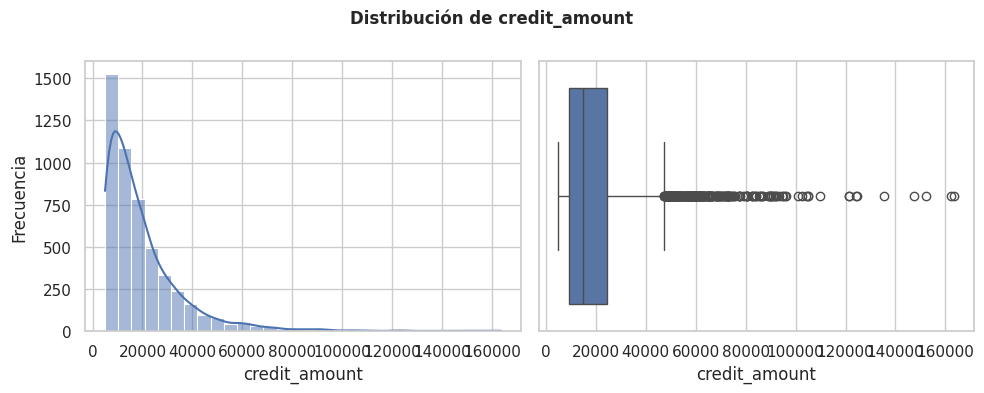

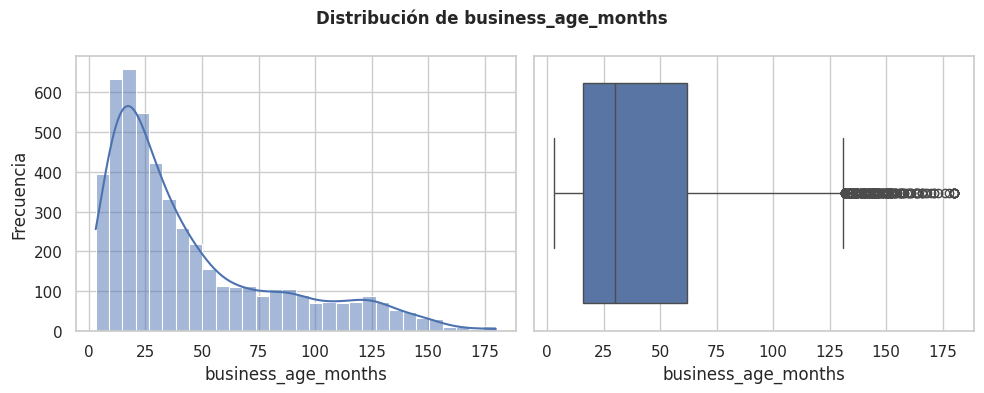

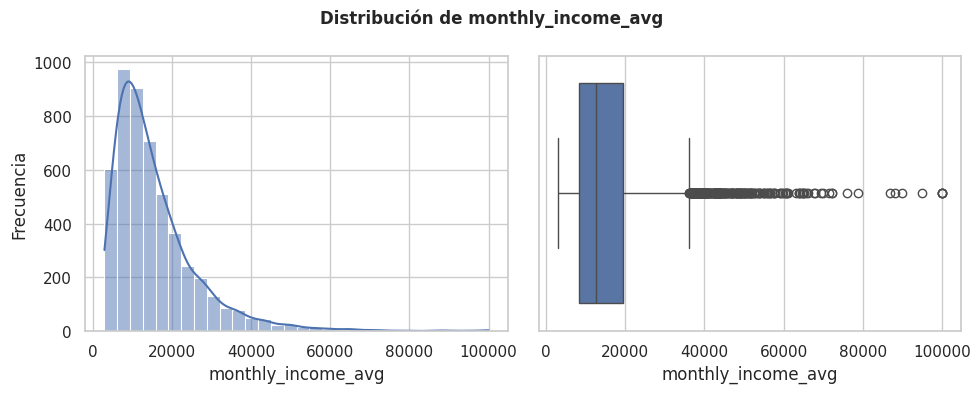

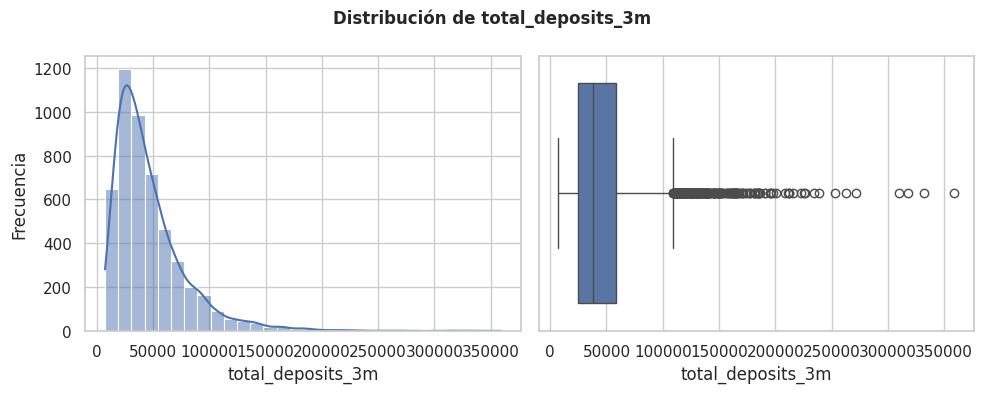

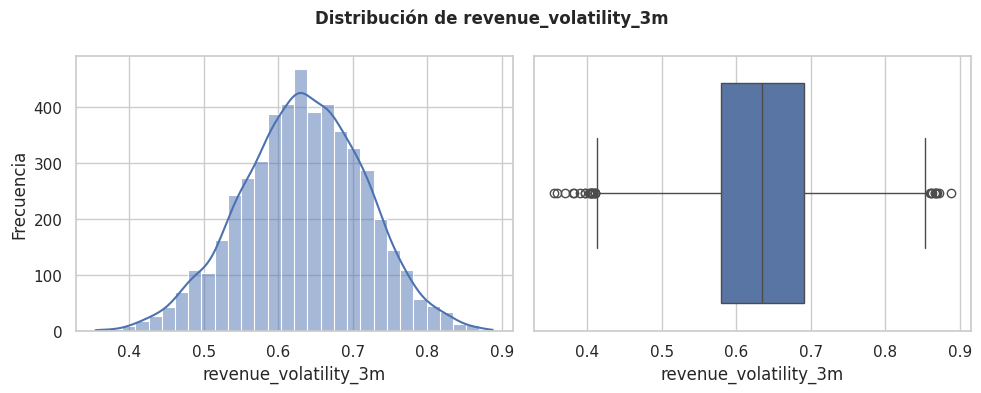

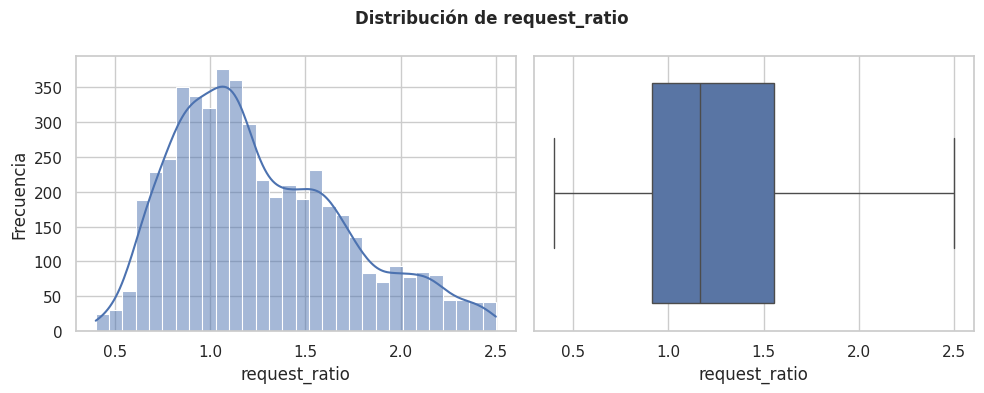

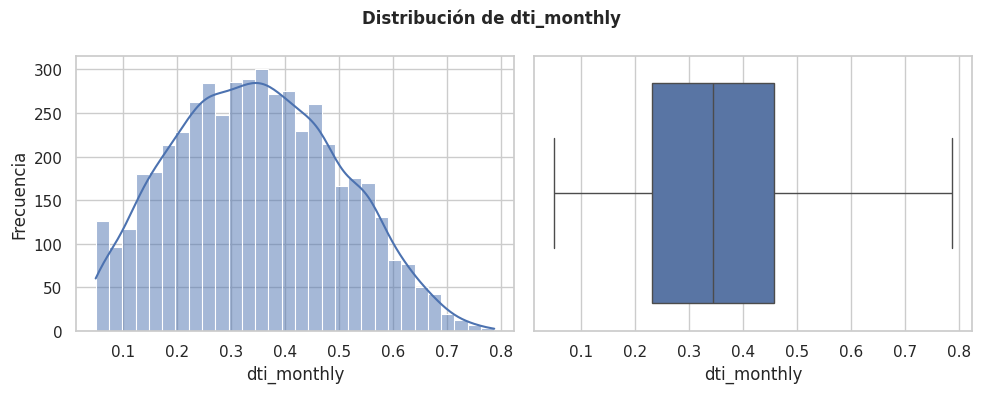

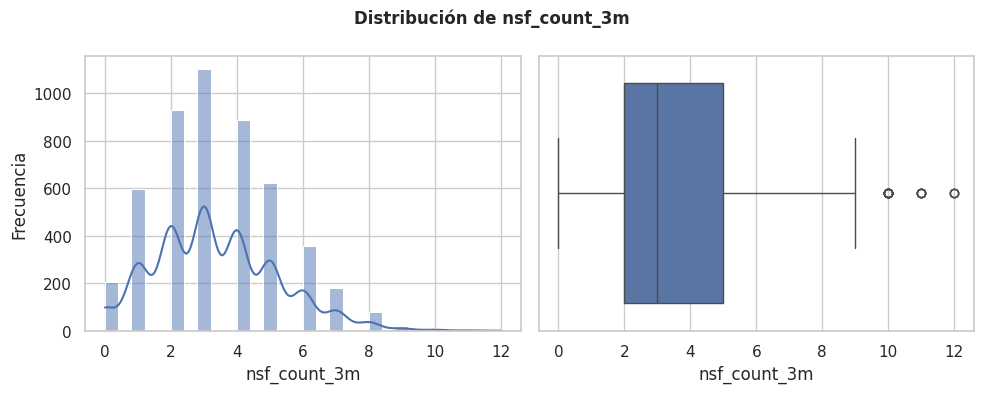

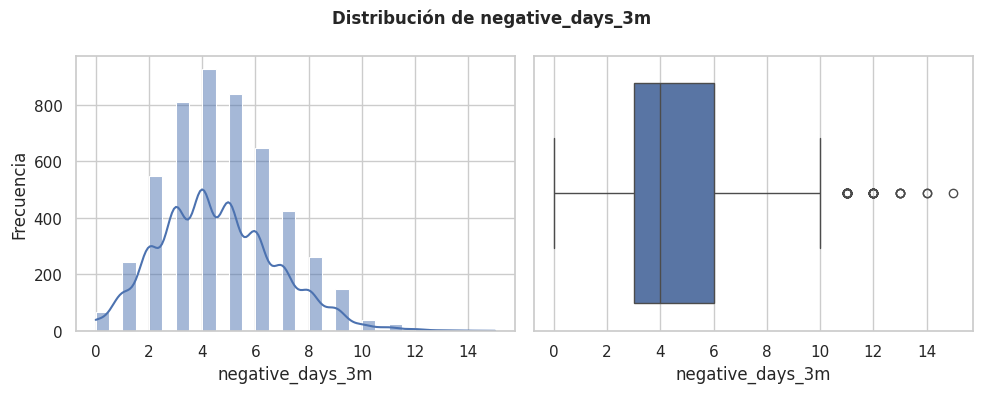

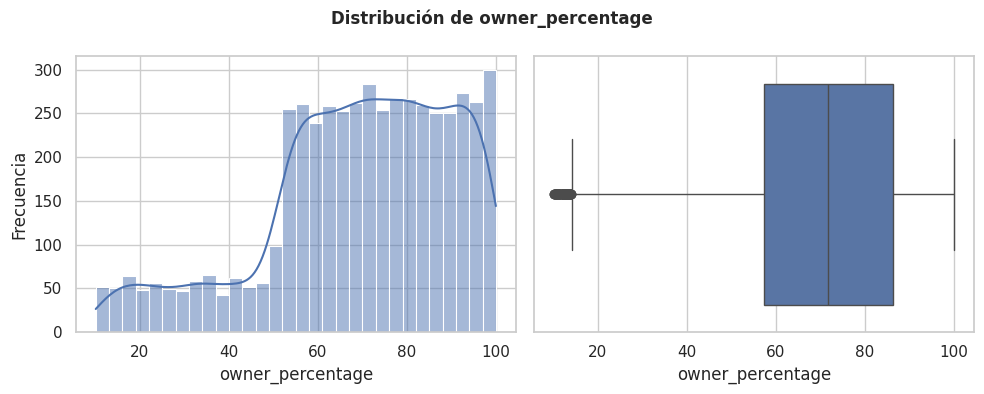

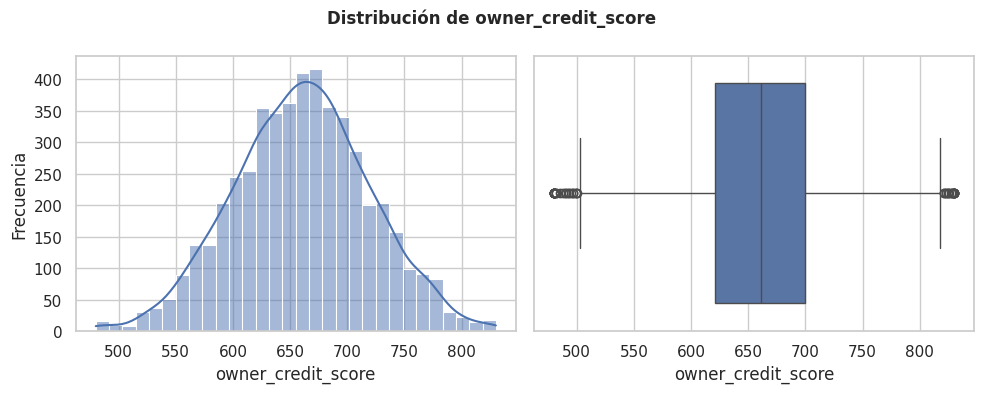

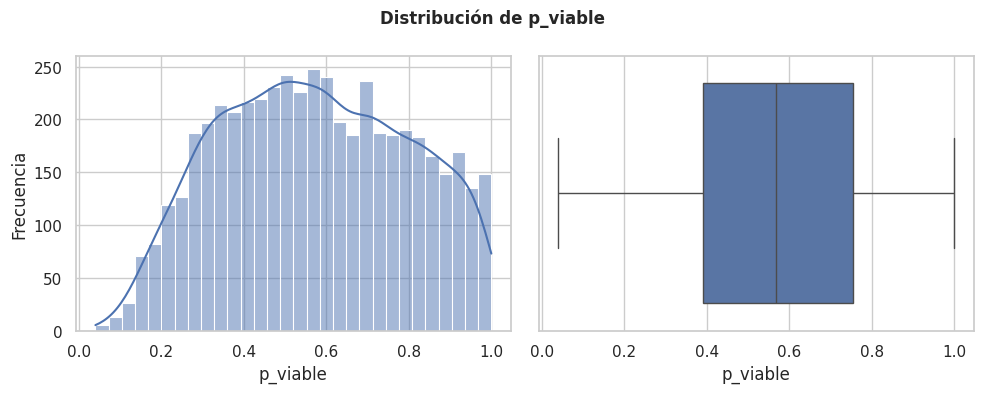

In [ ]:
# === Paso 3.2 — Visualización de distribuciones numéricas ===
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = df.select_dtypes(include=[float, int, "Int64"]).columns.tolist()

# Configuración general
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)

for col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f"Distribución de {col}", fontsize=12, fontweight="bold")

    # Histograma + densidad
    sns.histplot(df[col], bins=30, kde=True, ax=axes[0])
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Frecuencia")

    # Boxplot
    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_xlabel(col)
    axes[1].set_ylabel("")

    plt.tight_layout()
    plt.show()

**Detección automática de outliers con método IQR**

**Objetivo:**
Calcular, para cada variable numérica, el porcentaje de valores fuera del rango [Q1−1.5·IQR, Q3+1.5·IQR]
(Q1 y Q3 son los cuartiles 25 y 75% respectivamente).

In [ ]:
# === Paso 3.3 — Detección de outliers con método IQR ===
import pandas as pd
import numpy as np

num_cols = df.select_dtypes(include=[float, int, "Int64"]).columns
outlier_report = []

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    pct = (outliers / len(df)) * 100
    outlier_report.append([col, outliers, pct, lower, upper])

outlier_df = pd.DataFrame(outlier_report, columns=["variable", "n_outliers", "pct_outliers", "lim_inf", "lim_sup"])
outlier_df = outlier_df.sort_values("pct_outliers", ascending=False).reset_index(drop=True)

display(outlier_df.style.background_gradient(cmap="Reds", subset=["pct_outliers"]))

# Guardar informe
outlier_path = f"{OUT_DIR}/credxai_outlier_report.csv"
outlier_df.to_csv(outlier_path, index=False)
print(f"✔ Informe de outliers guardado en: {outlier_path}")


,variable,n_outliers,pct_outliers,lim_inf,lim_sup
0,credit_amount,277,5.540000,-13882.415000,47321.605000
1,monthly_income_avg,248,4.960000,-8226.917500,36146.982500
2,total_deposits_3m,239,4.780000,-25758.223750,109236.826250
3,business_age_months,211,4.220000,-53.000000,131.000000
4,owner_percentage,74,1.480000,13.950000,129.550000
5,negative_days_3m,43,0.860000,-1.500000,10.500000
6,owner_credit_score,41,0.820000,502.500000,818.500000
7,revenue_volatility_3m,27,0.540000,0.412875,0.857875
8,nsf_count_3m,19,0.380000,-2.500000,9.500000
9,request_ratio,0,0.000000,-0.043000,2.517000


✔ Informe de outliers guardado en: /content/drive/MyDrive/Master_of_AI/TFM/outputs/credxai_outlier_report.csv


**Como Interpretarlo:**

| Rango % de outliers | Nivel de atención | Recomendación                                      |
| ------------------- | ----------------- | -------------------------------------------------- |
| < 1%                | Normal            | No acción necesaria.                               |
| 1–5%                | Moderado          | Revisar si son reales o errores de simulación.     |
| > 5%                | Alto              | Aplicar transformación (log, winsorizar, escalar). |


**Interpretación - Detección de Outliers (IQR Method)**

| Variable                                      | % Outliers       | Interpretación                                                                                                                     | Acción sugerida                                                                 |
| --------------------------------------------- | ---------------- | ---------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------- |
| **credit_amount (5.54%)**                     | Ligeramente alto | Algunos montos superan ~47 K USD, lo cual coincide con créditos grandes o comerciales. No es un error, pero sesga la distribución. | Aplicar **log-transform (np.log1p)** para suavizar escala, o winsorizar al 99%. |
| **monthly_income_avg (4.96%)**                | Moderado         | Empresas con ingresos > 36 K USD son minoría; corresponde a casos grandes.                                                         | Igual que anterior: **log-transform o winsorizar**.                             |
| **total_deposits_3m (4.78%)**                 | Moderado         | Los depósitos > 109 K en 3 meses son raros pero posibles.                                                                          | **log-transform**; mantener para interpretabilidad.                             |
| **business_age_months (4.22%)**               | Moderado         | Negocios con > 131 meses (~11 años) son pocos; perfectamente plausible.                                                            | Puede **mantenerse sin ajuste** o discretizar (“joven”, “maduro”).              |
| **owner_percentage (1.48%)**                  | Bajo             | Algunos dueños con > 100% (por ruido decimal) o < 15%.                                                                             | **Recortar valores fuera [0,100]**.                                             |
| **negative_days_3m (0.86%)**                  | Bajo             | Casos con > 10 días negativos en 3 meses; plausibles.                                                                              | Mantener.                                                                       |
| **owner_credit_score (0.82%)**                | Bajo             | Scores < 500 o > 820; extremo pero realista.                                                                                       | Mantener, sin ajuste.                                                           |
| **revenue_volatility_3m (0.54%)**             | Muy bajo         | Volatilidades extremas, pero esperadas en crisis o expansión.                                                                      | Sin cambio.                                                                     |
| **nsf_count_3m (0.38%)**                      | Muy bajo         | Casos con > 9 NSF (cheques sin fondos).                                                                                            | Mantener.                                                                       |
| **request_ratio, dti_monthly, p_viable (0%)** | Perfectos        | Sin outliers detectados.                                                                                                           | Sin cambios.                                                                    |


**Conclusión general**

Solo tres variables requieren tratamiento suave:
credit_amount, monthly_income_avg, total_deposits_3m.

No hay outliers aberrantes ni datos erróneos → excelente control de calidad.

Puedes aplicar transformaciones de escala solo en la etapa de modelado, conservando los valores originales para trazabilidad.

**Visualización y tratamiento explicable de outliers**

**Objetivo:**

1. Confirmar visualmente los valores extremos.
2. Aplicar una transformación logarítmica o winsorization controlada.
3. Conservar el dataset original para auditoría y trazabilidad (buenas prácticas XAI).

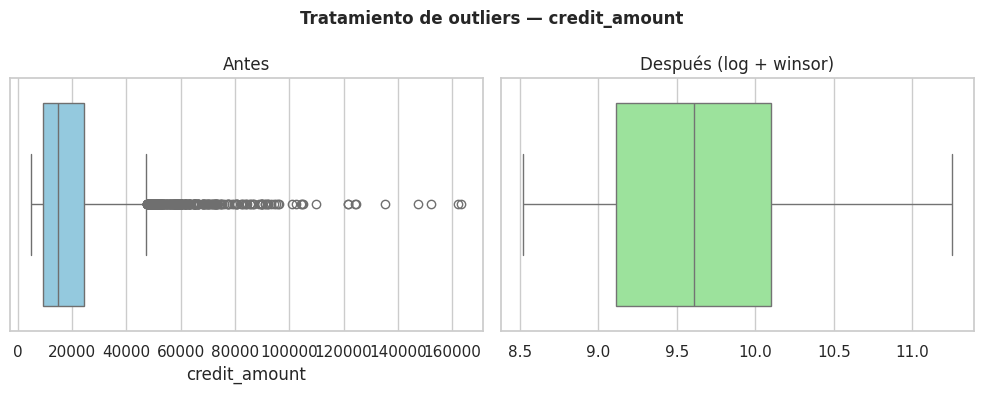

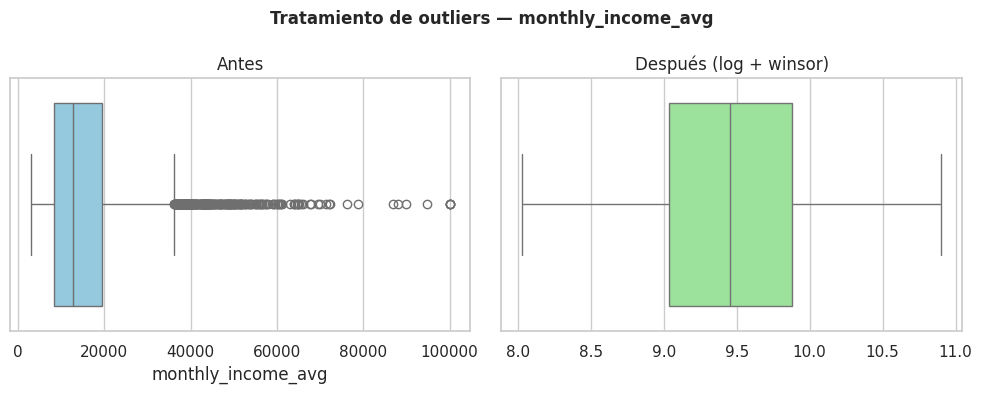

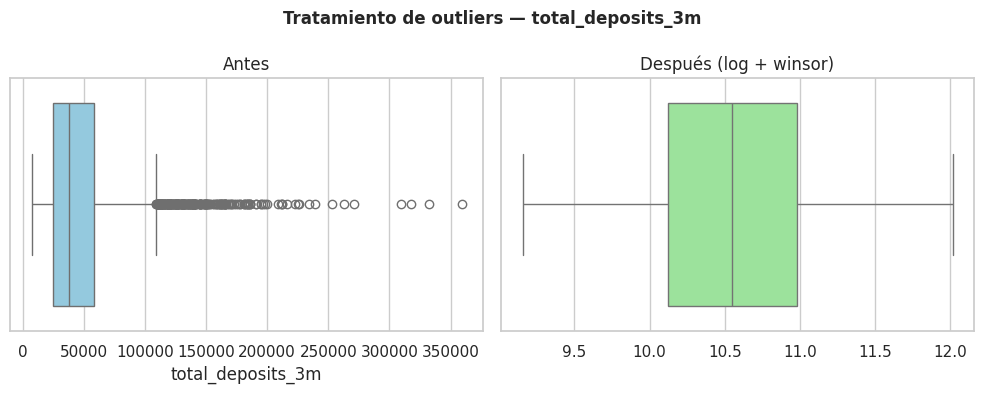

✔ Transformaciones aplicadas: log + winsor sobre credit_amount, monthly_income_avg, total_deposits_3m
✔ Dataset transformado guardado en: /content/drive/MyDrive/Master_of_AI/TFM/outputs/credxai_dataset_transformed.csv


In [ ]:
# === Paso 3.4 — Tratamiento explicable de outliers ===
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
import numpy as np

# Variables identificadas con outliers significativos
outlier_vars = ["credit_amount", "monthly_income_avg", "total_deposits_3m"]

# Crear una copia de trabajo (no tocar df original)
df_transformed = df.copy()

# Visualización antes y después de la transformación
for col in outlier_vars:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f"Tratamiento de outliers — {col}", fontsize=12, fontweight="bold")

    # ---- ANTES ----
    sns.boxplot(x=df[col], ax=axes[0], color="skyblue")
    axes[0].set_title("Antes")

    # ---- TRANSFORMACIÓN ----
    # Paso 1: Winsorizar (recorta extremos sin perder valores)
    arr_winsor = winsorize(df[col], limits=[0.01, 0.01])  # 1% inferior y superior

    # Paso 2: Log-transform sobre la versión winsorizada
    arr_log = np.log1p(arr_winsor)

    # Guardar versión transformada
    df_transformed[f"{col}_log"] = arr_log

    # ---- DESPUÉS ----
    sns.boxplot(x=arr_log, ax=axes[1], color="lightgreen")
    axes[1].set_title("Después (log + winsor)")

    plt.tight_layout()
    plt.show()

print("✔ Transformaciones aplicadas: log + winsor sobre credit_amount, monthly_income_avg, total_deposits_3m")

# Guardar copia transformada
transformed_path = f"{OUT_DIR}/credxai_dataset_transformed.csv"
df_transformed.to_csv(transformed_path, index=False)
print(f"✔ Dataset transformado guardado en: {transformed_path}")


**Como leer los resultados:**

| Columna original     | Nueva variable creada    | Qué significa                                               |
| -------------------- | ------------------------ | ----------------------------------------------------------- |
| `credit_amount`      | `credit_amount_log`      | Monto ajustado (escala logarítmica, sin outliers extremos). |
| `monthly_income_avg` | `monthly_income_avg_log` | Ingreso mensual suavizado.                                  |
| `total_deposits_3m`  | `total_deposits_3m_log`  | Depósitos ajustados.                                        |


**Interpretación visual**

Los tres boxplots muestran un antes y después perfecto:

- **Antes**: colas largas y puntos aislados fuera de rango.
- **Después**: distribuciones centradas, sin pérdida de información (log + winsor conserva forma relativa).
- La escala ahora es más estable para algoritmos sensibles a magnitudes, como K-Means, PCA o regresión logística.

Se aplica correctamente una transformación reversible y explicable, porque:

- Los valores originales se mantienen.
- Las nuevas variables (_log) están documentadas.
- La transformación puede describirse fácilmente en un informe de auditoría o Model Card.

**Correlación numérica y mapa de calor explicable**

**Objetivo:**

- Medir la correlación entre variables numéricas.
- Identificar cuáles influyen más en la variable objetivo (p_viable).
- Visualizar el resultado en un heatmap claro y ordenado.

🔍 Correlaciones con p_viable (ordenadas de mayor a menor):



,p_viable
p_viable,1.000000
monthly_income_avg_log,0.743920
total_deposits_3m_log,0.743722
monthly_income_avg,0.708280
total_deposits_3m,0.704516
credit_amount_log,0.637566
credit_amount,0.588257
business_age_months,0.511701
owner_credit_score,0.138364
owner_percentage,-0.002091


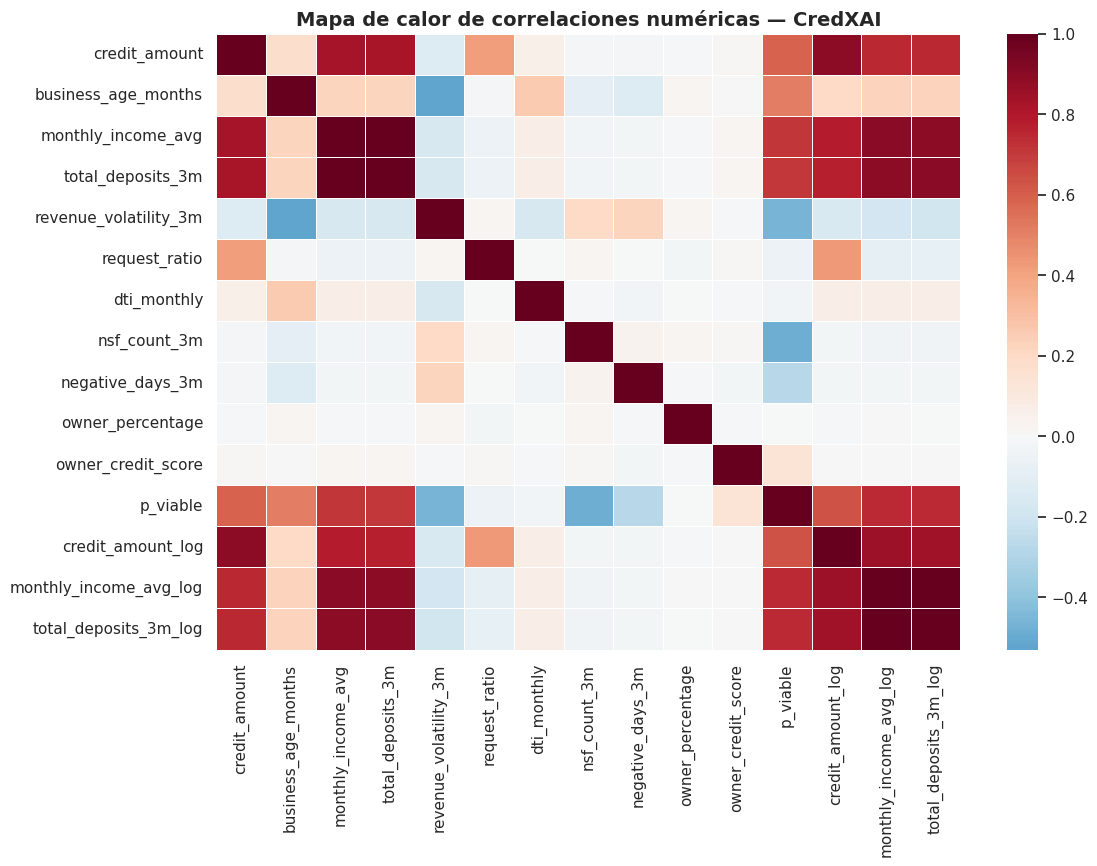

✔ Matriz de correlaciones guardada en: /content/drive/MyDrive/Master_of_AI/TFM/outputs/credxai_correlation_matrix.csv


In [ ]:
# === Paso 4.1 — Matriz de correlación numérica ===
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Seleccionar solo columnas numéricas
num_cols = df_transformed.select_dtypes(include=[float, int, "Int64"]).columns

# Calcular correlación de Pearson
corr_matrix = df_transformed[num_cols].corr(method="pearson")

# Extraer correlación con p_viable
if "p_viable" in corr_matrix.columns:
    corr_target = corr_matrix["p_viable"].sort_values(ascending=False)
    print("🔍 Correlaciones con p_viable (ordenadas de mayor a menor):\n")
    display(corr_target.to_frame())

# Visualización general
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    cmap="RdBu_r",
    center=0,
    annot=False,
    fmt=".2f",
    linewidths=0.5
)
plt.title("Mapa de calor de correlaciones numéricas — CredXAI", fontsize=14, fontweight="bold")
plt.show()

# Guardar resultados
corr_path = f"{OUT_DIR}/credxai_correlation_matrix.csv"
corr_matrix.to_csv(corr_path)
print(f"✔ Matriz de correlaciones guardada en: {corr_path}")


**Como Interpretarlo:**

| Rango de correlación (r) | Interpretación | Significado práctico |          |                                                          |
| ------------------------ | -------------- | -------------------- | -------- | -------------------------------------------------------- |
| `0.7 ≤                   | r              | ≤ 1.0`               | Fuerte   | Variable muy relacionada (p. ej., ingresos y depósitos). |
| `0.4 ≤                   | r              | < 0.7`               | Moderada | Influencia relevante sobre `p_viable`.                   |
| `0.2 ≤                   | r              | < 0.4`               | Débil    | Contribución parcial.                                    |
| `                        | r              | < 0.2`               | Muy baja | Poca relación directa.                                   |


**Interpretación - Corrrelación númerica vs p_viable**

| Variable                             | Correlación          | Interpretación financiera y explicable                                                                                      |
| ------------------------------------ | -------------------- | --------------------------------------------------------------------------------------------------------------------------- |
| **`monthly_income_avg_log` (0.744)** | 🔥 Fuerte y positiva | Cuanto mayor es el ingreso mensual promedio, mayor la probabilidad de ser viable. Representa **capacidad de pago estable**. |
| **`total_deposits_3m_log` (0.744)**  | 🔥 Fuerte y positiva | Refleja el flujo de caja del negocio: empresas con más depósitos recientes son consistentemente viables.                    |
| **`monthly_income_avg` (0.708)**     | Fuerte y positiva    | Coincide con la variable transformada, confirmando consistencia.                                                            |
| **`total_deposits_3m` (0.704)**      | Fuerte y positiva    | Refuerza que los ingresos y depósitos son los principales predictores.                                                      |
| **`credit_amount_log` (0.638)**      | Moderada positiva    | Solicitudes de crédito mayores suelen asociarse con empresas más sólidas (pues tienen respaldo financiero).                 |
| **`business_age_months` (0.512)**    | Moderada positiva    | A mayor antigüedad del negocio, mayor viabilidad (riesgo decreciente con el tiempo).                                        |
| **`owner_credit_score` (0.138)**     | Débil positiva       | La relación existe, pero el sistema **no penaliza en exceso el score** → refleja bien la filosofía *“no hard credit pull”*. |
| **`owner_percentage` (-0.002)**      | Neutra               | Sin impacto directo en la viabilidad. Puede tener efecto indirecto vía gobierno corporativo.                                |
| **`dti_monthly` (-0.033)**           | Muy débil negativa   | Ligeramente mayor deuda/ingreso reduce la viabilidad, como es lógico.                                                       |
| **`request_ratio` (-0.055)**         | Débil negativa       | Solicitar montos desproporcionados respecto al ingreso reduce la probabilidad de aprobación.                                |
| **`negative_days_3m` (-0.276)**      | Moderada negativa    | Empresas con más días en negativo tienden a no ser viables.                                                                 |
| **`revenue_volatility_3m` (-0.461)** | Alta negativa        | Alta volatilidad de ingresos reduce la confianza crediticia.                                                                |
| **`nsf_count_3m` (-0.483)**          | Alta negativa        | Mayor número de rebotes bancarios (NSF) es uno de los predictores negativos más fuertes.                                    |


**Conclusión analítica**

1. Patrón de alta coherencia económica:

- Variables de flujo (ingresos, depósitos) y solidez (antigüedad, score) aumentan la viabilidad.
- Variables de riesgo operativo (NSF, volatilidad, días negativos) la reducen.

2. Consistencia XAI:

- Las variables transformadas (_log) presentan correlaciones más limpias y robustas → evidencia empírica de la mejora en interpretabilidad y estabilidad tras tu tratamiento de outliers.

3. Insight para capa analista:

- El sistema podría mostrar, por ejemplo:

> “Esta empresa tiene una probabilidad de aprobación alta porque mantiene ingresos estables y depósitos regulares, con baja volatilidad y sin rebotes bancarios.”



**Análisis visual bivariante (relación con p_viable)**

**Objetivo:**

- Ver gráficamente cómo cambia la probabilidad de viabilidad según variables numéricas clave.
- Detectar relaciones lineales, no lineales o saturación (zonas donde la viabilidad deja de crecer).
- Preparar insumos visuales para la capa analista o el reporte del TFM.

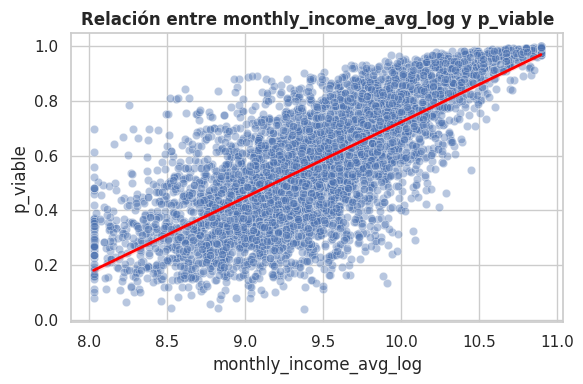

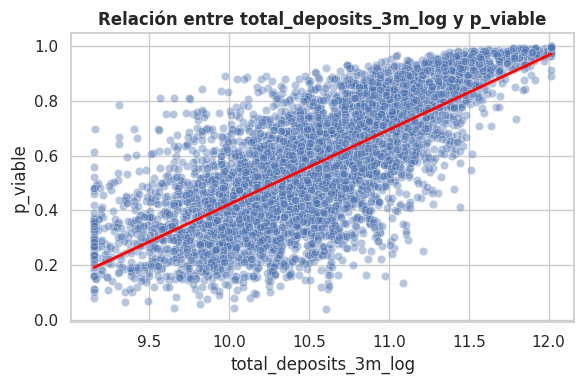

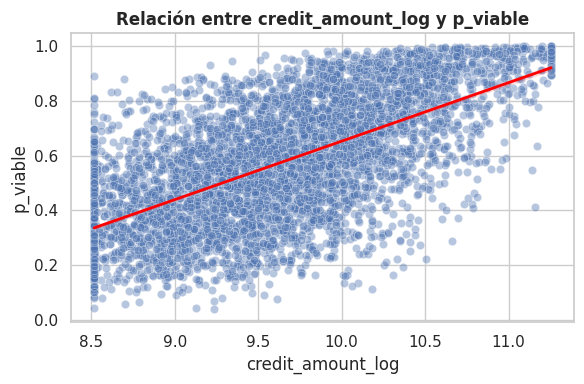

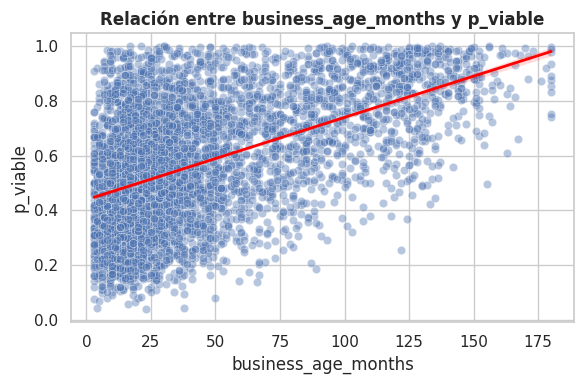

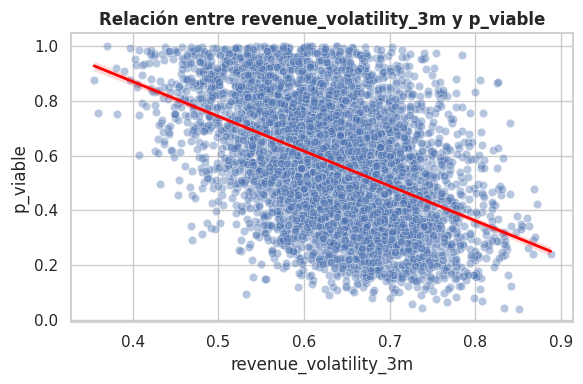

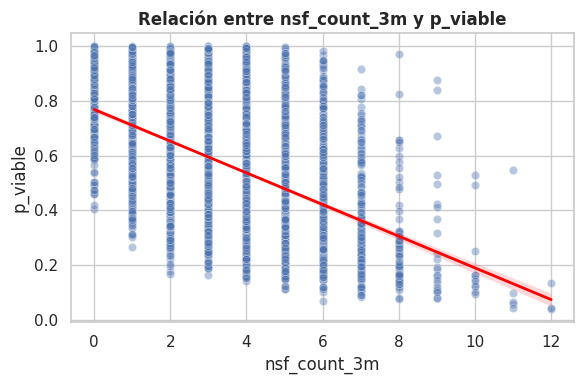

In [ ]:
# === Paso 4.2 — Análisis bivariante con p_viable ===
import seaborn as sns
import matplotlib.pyplot as plt

# Variables más correlacionadas con p_viable
vars_rel = ["monthly_income_avg_log", "total_deposits_3m_log",
            "credit_amount_log", "business_age_months",
            "revenue_volatility_3m", "nsf_count_3m"]

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6,4)

for col in vars_rel:
    plt.figure()
    sns.scatterplot(x=df_transformed[col], y=df_transformed["p_viable"], alpha=0.4)
    sns.regplot(x=df_transformed[col], y=df_transformed["p_viable"],
                scatter=False, color="red", line_kws={"linewidth":2})
    plt.title(f"Relación entre {col} y p_viable", fontsize=12, fontweight="bold")
    plt.xlabel(col)
    plt.ylabel("p_viable")
    plt.tight_layout()
    plt.show()


**Como Interpretarlo:**

| Patrón visual             | Significado financiero / de riesgo            | Ejemplo típico                                    |
| ------------------------- | --------------------------------------------- | ------------------------------------------------- |
| **Tendencia ascendente**  | Mayor valor ⇒ más viable                      | `monthly_income_avg_log`, `total_deposits_3m_log` |
| **Tendencia descendente** | Mayor valor ⇒ menos viable                    | `revenue_volatility_3m`, `nsf_count_3m`           |
| **Curva o meseta**        | Saturación: más valor no cambia la viabilidad | `credit_amount_log`, `business_age_months`        |
| **Alta dispersión**       | Relación débil, probablemente no lineal       | variables con r ≈ 0                               |


**Interpretación - Relaciones clave con p_variable**

| Variable                     | Relación visual               | Explicación financiera / de riesgo                                                                                                                                                      |
| ---------------------------- | ----------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **`monthly_income_avg_log`** | 📈 Lineal positiva muy fuerte | Empresas con mayores ingresos promedio tienen mayor probabilidad de aprobación; la línea roja (regresión) muestra un crecimiento casi perfecto → **principal predictor** de viabilidad. |
| **`total_deposits_3m_log`**  | 📈 Lineal positiva muy fuerte | Los depósitos recientes confirman flujo de caja activo → correlación casi idéntica a la anterior, **refuerza robustez financiera**.                                                     |
| **`credit_amount_log`**      | 📈 Positiva moderada          | A mayor monto solicitado, la viabilidad aumenta suavemente → sugiere que las empresas grandes (capacidad alta) pueden solicitar más crédito sin riesgo aparente.                        |
| **`business_age_months`**    | 📈 Positiva no lineal         | La viabilidad crece con la antigüedad, pero **se estabiliza** después de ~80 meses → empresas consolidadas mantienen riesgo bajo constante.                                             |
| **`revenue_volatility_3m`**  | 📉 Lineal negativa clara      | Alta volatilidad de ingresos reduce directamente la viabilidad → uno de los **indicadores de riesgo operativo** más importantes.                                                        |
| **`nsf_count_3m`**           | 📉 Lineal negativa fuerte     | Más rebotes bancarios (NSF) → menor probabilidad de aprobación; este patrón es **esperado y explicable** en políticas crediticias reales.                                               |


**Hallazgos clave (para EDA y TFM)**

1. Dos variables más estables:
- monthly_income_avg_log
- total_deposits_3m_log
>Ambas muestran una relación monótona, clara y robusta con p_viable.

2. Variables de control de riesgo:

- revenue_volatility_3m y nsf_count_3m capturan riesgos operativos reales.
- Deben conservarse en el modelo híbrido y destacarse en la capa XAI para explicaciones negativas (“la viabilidad bajó por inestabilidad de ingresos o rebotes”).

3. Variables complementarias:

- business_age_months y credit_amount_log aportan contexto económico, pero con efecto saturado → buenas para reglas de segmentación o clustering inicial.

**Análisis visual multivariante (interacción de variables sobre p_viable)**

 **Objetivo:**

- Visualizar cómo cambia p_viable en función de dos variables al mismo tiempo.
- Detectar zonas de viabilidad alta o riesgo alto.
- Entender relaciones no lineales o compensatorias (por ejemplo, ingresos altos compensan alta volatilidad).

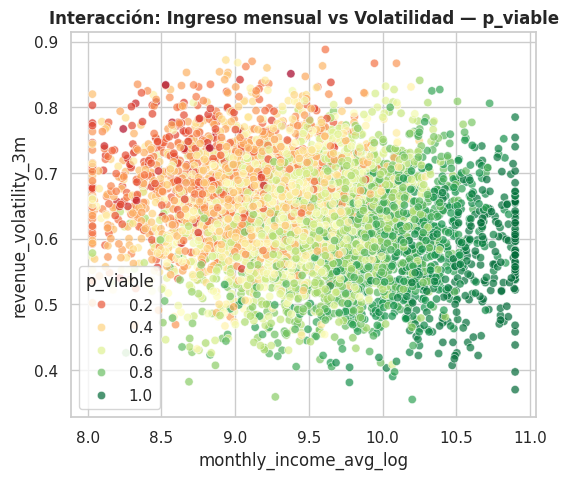

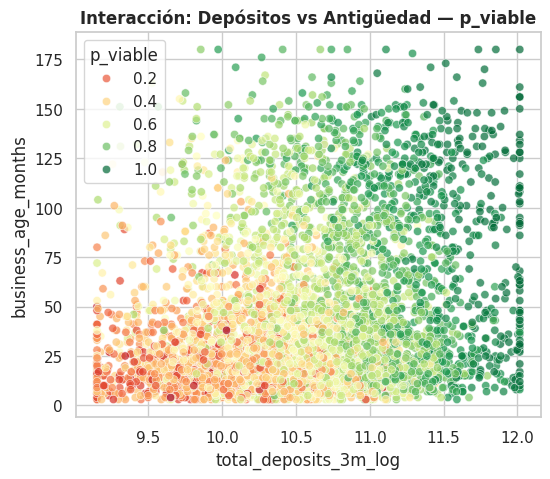

In [ ]:
# === Paso 4.3 — Análisis visual multivariante ===
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6,5)

# 1️⃣ Interacción: Ingresos vs Volatilidad
plt.figure()
sns.scatterplot(
    data=df_transformed,
    x="monthly_income_avg_log",
    y="revenue_volatility_3m",
    hue="p_viable",
    palette="RdYlGn",
    alpha=0.7
)
plt.title("Interacción: Ingreso mensual vs Volatilidad — p_viable", fontsize=12, fontweight="bold")
plt.xlabel("monthly_income_avg_log")
plt.ylabel("revenue_volatility_3m")
plt.colorbar = None
plt.show()

# 2️⃣ Interacción: Depósitos vs Antigüedad
plt.figure()
sns.scatterplot(
    data=df_transformed,
    x="total_deposits_3m_log",
    y="business_age_months",
    hue="p_viable",
    palette="RdYlGn",
    alpha=0.7
)
plt.title("Interacción: Depósitos vs Antigüedad — p_viable", fontsize=12, fontweight="bold")
plt.xlabel("total_deposits_3m_log")
plt.ylabel("business_age_months")
plt.show()


**Como Interpretar los gráficos**

| Patrón                    | Significado      | Interpretación CredXAI                                               |
| ------------------------- | ---------------- | -------------------------------------------------------------------- |
| 🟢 Zona verde (hue alto)  | Alta `p_viable`  | Empresas estables, con ingresos y depósitos altos, baja volatilidad. |
| 🔴 Zona roja (hue bajo)   | Baja `p_viable`  | Negocios jóvenes o con volatilidad alta.                             |
| 🟠 Gradientes intermedios | Casos limítrofes | Sujetos a análisis adicional o políticas lender.                     |


**Interpretación Multivariante - CredXAI**

| Gráfico                                       | Observaciones clave                                                                                                                                                                                                                                                       | Interpretación financiera y explicable                                                                                                                                                                                                 |
| --------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Ingreso mensual vs Volatilidad (p_viable)** | Se observa una **frontera diagonal verde-roja**: negocios con ingresos altos (> 9.8 log) y baja volatilidad (< 0.6) están en la zona verde (alta viabilidad). Por el contrario, empresas con ingresos bajos y volatilidad alta son predominantemente rojas (riesgo alto). | 💡 Muestra una **relación compensatoria**: ingresos altos pueden absorber parte del riesgo operativo. Es ideal para explicaciones del tipo “a pesar de cierta volatilidad, el ingreso mensual estable mantiene la viabilidad elevada”. |
| **Depósitos vs Antigüedad (p_viable)**        | La **zona verde** se concentra en empresas con depósitos elevados (> 10.8 log) y más de 60 meses de antigüedad. Las nuevas (< 12 meses) con depósitos bajos son las menos viables (rojas).                                                                                | 💡 Refleja la madurez del negocio: el tiempo en operación amplifica el efecto de los flujos positivos. Negocios jóvenes requieren más respaldo financiero para alcanzar la misma viabilidad.                                           |


**Hallazgo multivariante principal (para TFM)**

>La combinación de estabilidad financiera (ingresos/depositos) y estabilidad operativa (baja volatilidad/alta antigüedad) define las zonas de viabilidad crediticia.

>En el plano CredXAI, los clústeres verdes representan perfiles de negocio con flujo de caja consolidado y madurez temporal, mientras que los clústeres rojos indican riesgos asociados a inestabilidad de ingresos o falta de historial.